In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
dataset_train = pd.read_csv('D:\\ML\\DeepLearningCourse\\Recurrent_Neural_Networks\\Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
training_set = dataset_train.iloc[:, 1:2].values
# we use open price

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
# Creating a data structure with 60 timesteps and 1 output
# so our model will look at 60 observation and after every 60 observations it will make one prediction
X_train = []
y_train = []
for i in range(60, 1258):  # 1258 is the number of observations we have
    X_train.append(training_set_scaled[i-60:i, 0])
    # we extract all values in training_set_scaled in column 0 from row i-60 to i(0 to 59 in first case)
    y_train.append(training_set_scaled[i, 0])
    # we extract column 0 and row i from training_set_scaled

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# first dimension corresponds to complete batch size, second dimension corresponds to timesteps and third dimension corresponds to number of features/indicators
# we reshape our X_train into a 3d matrix, (1198, 60) -> (1198, 60, 1)
print(X_train.shape)
print(y_train.shape)

(1198, 60, 1)
(1198,)


# Model and Training

In [6]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [7]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0461 - accuracy: 0.0017
Epoch 2/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0060 - accuracy: 0.0017
Epoch 3/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 0.0017
Epoch 4/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0056 - accuracy: 0.0017
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0052 - accuracy: 0.0017
Epoch 6/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0049 - accuracy: 0.0017
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.0017
Epoch 8/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.0017
Epoch 9/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 0.0017
Epoch 10/100
38/38 [==============================] - 1s 17ms/step - loss: 0.0042 - accuracy: 0.0017

# Testing

In [8]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_prices = dataset_test.iloc[:, 1:2].values

In [9]:
# Getting predicted values of google stock price for the next month where the training set ends
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
# to predict stock price of one day we will need all the stock prices of 60 days before that day which will come from both training and test set
# therefore we concatenate the training and test sets

In [10]:
inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:]
# inputs contains all the values we are going to need for making predictions of stock prices for one month after the training dataset
inputs = inputs.values.reshape(-1, 1)
print(inputs.shape)
# 80 because one month only has 20 financial days (20+60)

(80, 1)


In [11]:
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):  # 20 financial days in one month
    X_test.append(inputs[i-60:i, 0])
    # stores all 20 arrays containing 60 values used for making prediction for each financial day in a month
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

In [12]:
predicted_stock_prices = regressor.predict(X_test)
predicted_stock_prices = sc.inverse_transform(predicted_stock_prices)
predicted_stock_prices.shape

(20, 1)

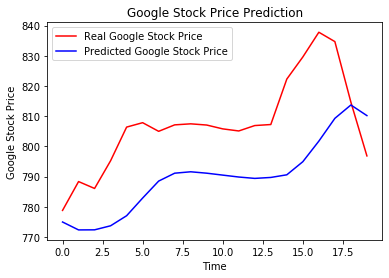

In [13]:
plt.plot(real_stock_prices, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_prices, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()